# Project 3

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle

In [2]:
def show_fig(picture, fig = (10,10)):
    plt.figure(figsize=fig)
    plt.imshow(cv2.cvtColor(picture, cv2.COLOR_BGR2RGB))
#     plt.imshow(picture)
    plt.show()

In [3]:
def matching(features1, features2, kp1, kp2, KNN = True):
    # create BFMatcher object
    pts1, pts2 = [], []
    
    if KNN:
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(features1,features2, k=2)
        
        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append(m)
                pts2.append(kp2[m.trainIdx].pt)
                pts1.append(kp1[m.queryIdx].pt)
        matches = good
    else:
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(features1,features2)
    
#     Sort them in the order of their 'distance' attribute (sorting in the order of match quality)
#     matches = sorted(matches, key = lambda x:x.distance)
    
    return matches, pts1, pts2

In [4]:
def calculate_pts(keypoints1, keypoints2, mtchs):
#     kps1 = np.float32([kp.pt for kp in keypoint_1])
#     kps2 = np.float32([kp.pt for kp in keypoint_2])

    # construct the two sets of points
#     src_pts = np.float32([kps1[m.queryIdx] for m in mtchs])
#     dst_pts = np.float32([kps2[m.trainIdx] for m in mtchs])
    
    MIN_MATCH_COUNT = 40
#     if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in mtchs ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in mtchs ]).reshape(-1,1,2)
    
    return src_pts, dst_pts

In [5]:
def choose_pts(p1, p2, kp, match):
    ptsA, ptsB, kpIdx, kpChosen, matchChosen = [], [], [], [], []
    for i in range(0, len(p1)):
        flag = 0
        for j in ptsA:
            if np.linalg.norm(p1[i] - j) < 40:
                flag = 1
                break
        if flag == 0:
            ptsA.append(p1[i])
            ptsB.append(p2[i])
            kpIdx.append(i)
            kpChosen.append(kp[i])
            matchChosen.append(match[i])
#         if len(ptsA) == 40:
#             break   

    return ptsA, ptsB, kpChosen, matchChosen

In [6]:
images = []
pictures = 'buddha_images/'

#Read the images 
pics = os.listdir(pictures)
pics.sort()

for filename in pics:
    print(filename)
    images.append(cv2.imread(pictures+'/'+filename,1))

#incase file considers .gitkeep file along with images
# images = images[1:]
    
width = images[0].shape[1]
height = images[0].shape[0]

buddha_001.png
buddha_002.png
buddha_003.png
buddha_004.png
buddha_005.png
buddha_006.png
buddha_007.png
buddha_008.png
buddha_009.png
buddha_010.png
buddha_011.png
buddha_012.png
buddha_013.png
buddha_014.png
buddha_015.png
buddha_016.png
buddha_017.png
buddha_018.png
buddha_019.png
buddha_020.png
buddha_021.png
buddha_022.png
buddha_023.png
buddha_024.png


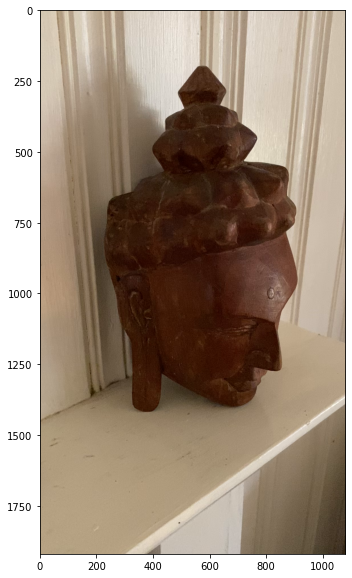

In [7]:
show_fig(images[0])

In [8]:
def featureDetectSift(img):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 4000, contrastThreshold = 0.0025, edgeThreshold=5, sigma = 1.5, nOctaveLayers = 12)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     norm_img = cv2.normalize(images[i], None, 0, 255, norm_type=cv2.NORM_MINMAX)
#     blur = cv2.GaussianBlur(images[i],(7,7),0)
    keypts, descrptr = sift.detectAndCompute(gray,None)
    return keypts, descrptr

In [11]:
kps, desc = [], []
n = len(images)
for i in range(0, n):
    keypts,descrptr = featureDetectSift(images[i])
    kps.append(keypts)
    desc.append(descrptr)

In [12]:
matches, srcPts, dstPts, kpsIdx = [], [], [], []
FILTER_MATCHES = False

for i in range(0, n):
    good, src_pts_temp, dst_pts_temp = matching(desc[i], desc[(i+1)%n], kps[i], kps[(i+1)%n])
#     (src_pts_temp, dst_pts_temp) = calculate_pts(kps[i], kps[(i+1)%n], good)
    
    if FILTER_MATCHES:
        src_pts_temp, dst_pts_temp, Idx_temp, good, matchesChosen = choose_pts(src_pts_temp, dst_pts_temp, kps, good)
        kpsIdx.append(np.array(Idx_temp))
    
    srcPts.append(np.array(src_pts_temp))
    dstPts.append(np.array(dst_pts_temp))
    matches.append(good)

In [13]:
# Plotting the features matched: Uncomment to plot the image matches
# for i in range (0, n-1):
#     plotting_img = cv2.drawMatches(images[i],kps[i],images[(i+1)%n],kps[(i+1)%n],matches[i],None,flags=2)
#     print('Matches of images ',i+1,1+(i+1)%n,':')
#     show_fig(plotting_img)

In [14]:
sensor_sz = np.array([4.55, 6.17])
f = 26
img_sz = np.array([1080, 1920])
f_px = f*(img_sz/sensor_sz)

K = np.array([[f_px[0], 0.0,     img_sz[0]/2],
             [0.0,      f_px[1], img_sz[1]/2],
             [0.0,      0.0,     1.0]], dtype = np.float64)

In [15]:
prev_transformation_matrix = np.eye(4)
prev_projection_matrix = K.dot(np.hstack((np.eye(3), np.zeros((3, 1)))))
points = []
points_frame = []
points_len = 0

In [16]:
for i in range(0, n):
    print(i)
    dst_points, src_points = dstPts[i], srcPts[i]
    
#     essential_matrix, essential_mask = cv2.findEssentialMat(dst_points, src_points, K, cv2.RANSAC, 0.999, 1.0)
    essential_matrix, essential_mask = cv2.findEssentialMat(src_points, dst_points, K, cv2.RANSAC, 0.999, 1.0)
    
#     _, rotation_matrix, translation, pose_mask = cv2.recoverPose(essential_matrix, dst_points, src_points, K)
    _, rotation_matrix, translation, pose_mask = cv2.recoverPose(essential_matrix, src_points, dst_points, K)
    
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :] = np.hstack((rotation_matrix, translation)).dot(prev_transformation_matrix)
    
    projection_matrix = K.dot(np.linalg.inv(transformation_matrix)[:3])
    
    object_points = cv2.triangulatePoints(prev_projection_matrix, projection_matrix, src_points.T, dst_points.T)
    
    object_points /= object_points[3]
    
#     points.append(np.reshape(object_points[:3], (3, max(object_points.shape))))
    points_frame.append(object_points[:3])
    if i == 0:
        points = object_points[:3]
    else:
        points = np.concatenate((points, object_points[:3]), axis=1)
        
    prev_transformation_matrix = transformation_matrix
    prev_projection_matrix = projection_matrix
    points_len += max(object_points.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [17]:
# Deleting stray points for better vizualization of plot
i = 0
while i < points.shape[1]:
    if abs(np.linalg.norm(points.T[i])) > 50:
        print(i)
        points = np.delete(points, i, axis=1)
    else:
        i = i+1

0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24


<IPython.core.display.Javascript object>


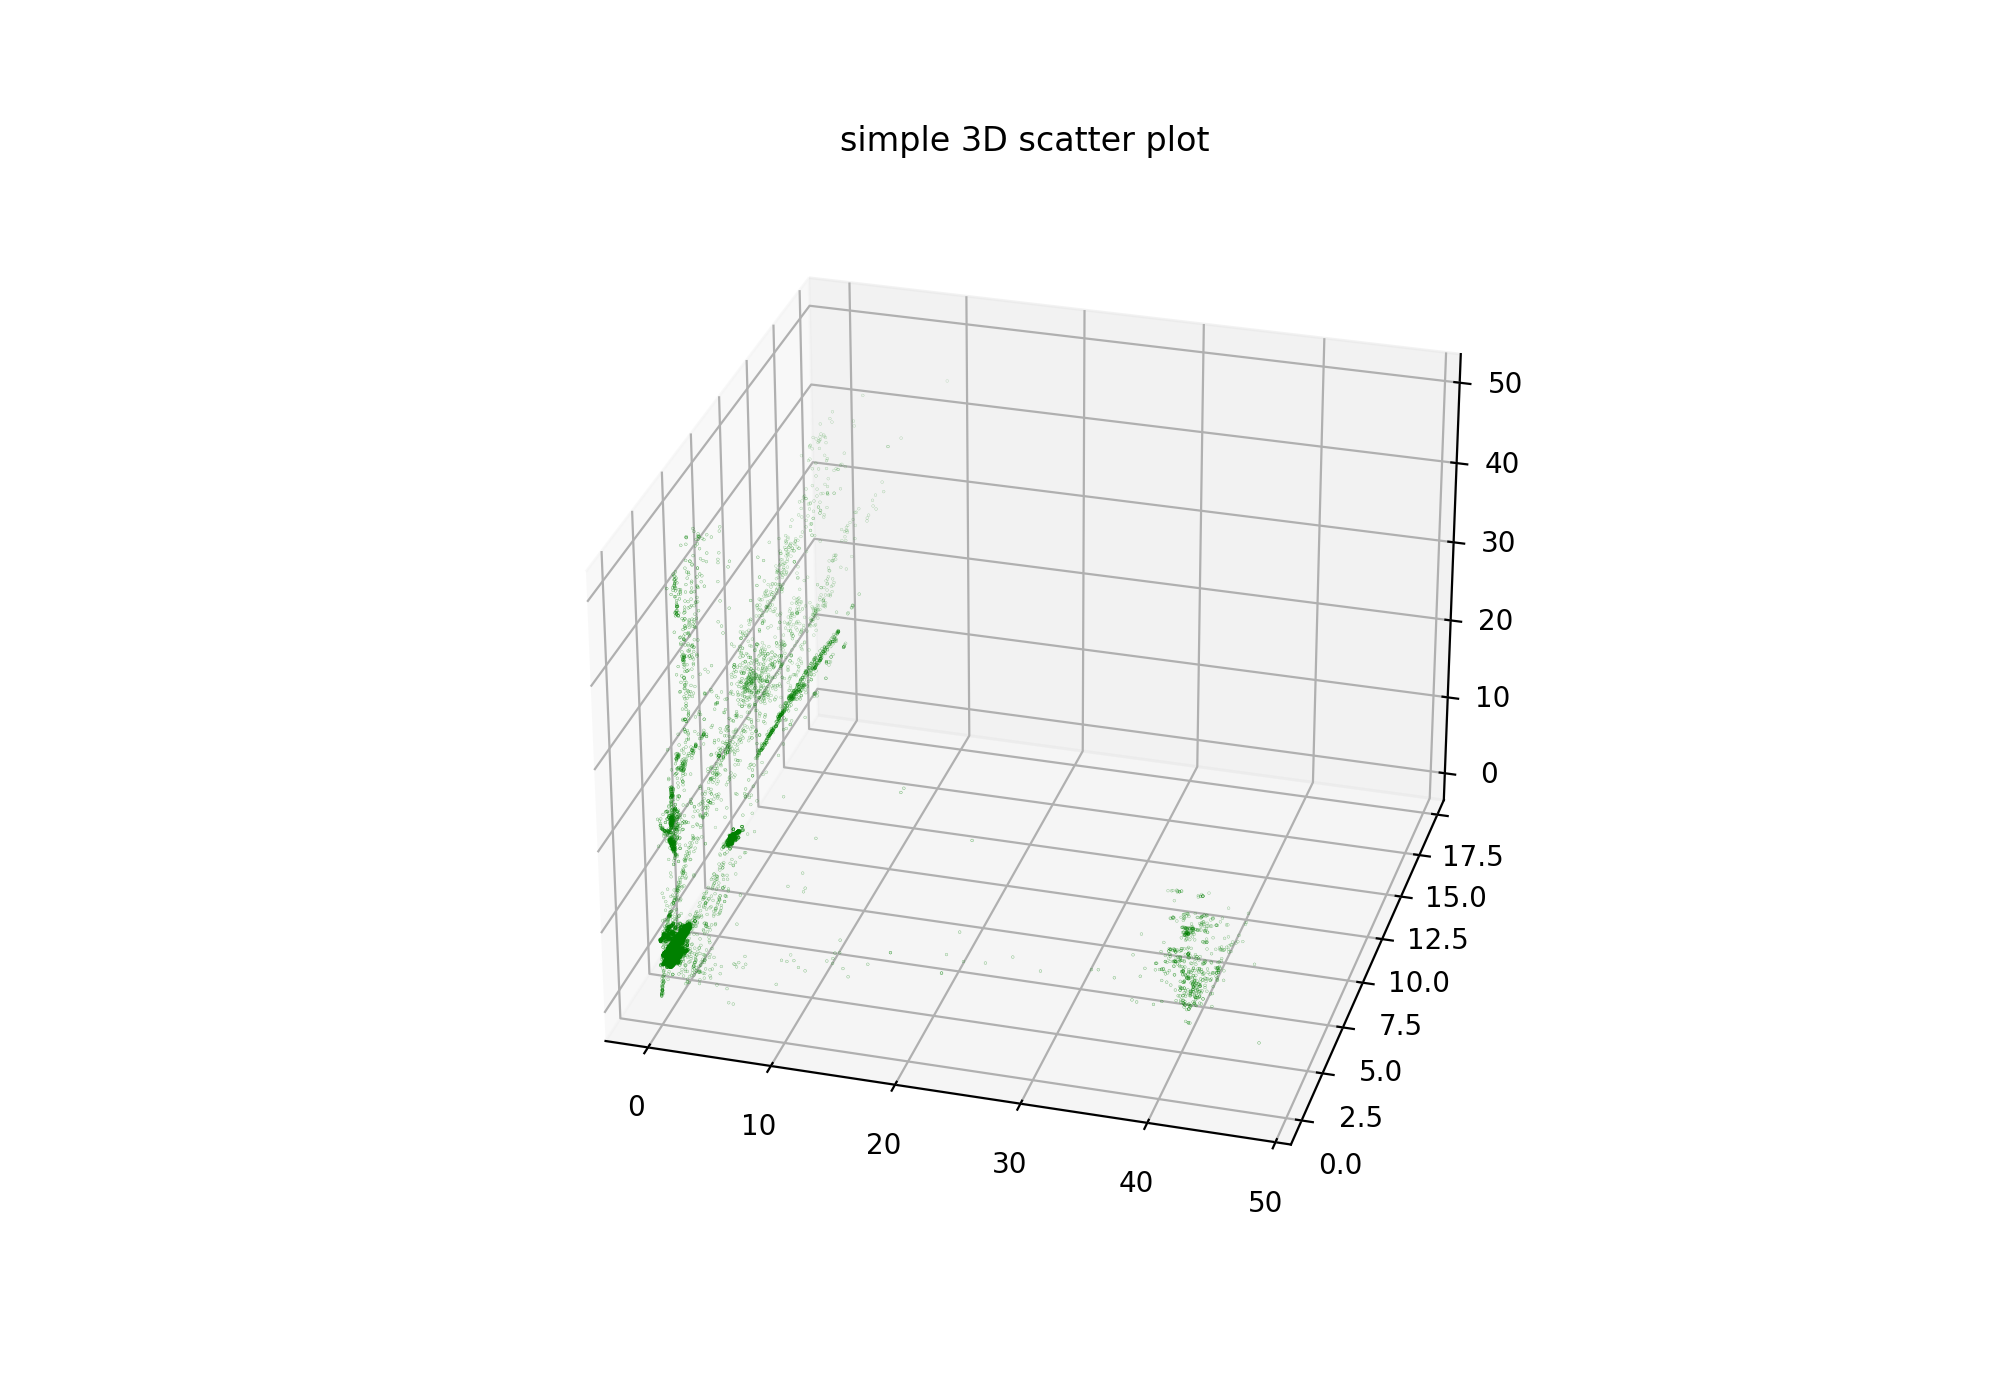

In [18]:
%matplotlib notebook

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(abs(points[0]), abs(points[1]), abs(points[2]), color = "green", s = 0.01)
plt.title("simple 3D scatter plot")
plt.show()

### Ouput summary:

As can be seen in the plot above, the points do not resemble the face of the buddha that we would expect from the images. One issue might be some error in the projection code which could not be identified despite repeated attempts to debug. Another solution to getting a better projection estimate could be to optimize the projections using GTSAM.